# Introduction

Notebook to test 'n' day forecast on ten (out of 100 selectyed stocks). The purpose of this notebook is to test out the code written in a separate file `frankie.py`. `frankie.py` contains the DayForecast class and general support functions to optimize the parameters, to calculate the naive baseline for the specified period, and to calculate the true positive rate (TPR) over different periods to get a sense of how well the model performs under different market conditions.

Note: the code and notebook rely on the `yfinance` library for collecting the daily stock data. More info can be found at (https://pypi.org/project/yfinance/)

In [1]:
import pandas as pd
from frankie import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf
import gc; gc.enable()

import math 
import random

import warnings
warnings.filterwarnings("ignore")

Force the notebook to put all output in the notebook withoout having to scroll. This is easier to see and work with. The cell below uses Java script to take care of that. 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
LAGS=[1, 3, 5, 10, 20, 30]

## Test Five Day Forecast on MSFT

The cell below calls the DayForecast class to build an auto regressive with exogenuous variable (ARX) time series model. The model is then uised to forecast from `split_date` until the end of the available data (`2020-02-07'). It also shows the model coefficients for the mean model, volatility model, and the Students T distribution. Since we selected `verbose=True` we get the confusion matrix which shows that the true positive rate (TPR) is good and shows that the model does a good joib predicting the percentage change five days ahead. Over the period from 2019-07-01 it only makes four (4) mistakes out of one hundred seven "up" days, so it achieves a TPR of 96 %. The charts at the end show the data from 2019-07-01 onwards, as well as the y actuals versus y predictions, and the last 20 data poinbts predicted.

                           AR - TARCH/ZARCH Model Results                           
Dep. Variable:                        Close   R-squared:                       0.637
Mean Model:                              AR   Adj. R-squared:                  0.636
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -4552.39
Distribution:      Standardized Student's t   AIC:                           9128.78
Method:                  Maximum Likelihood   BIC:                           9197.79
                                              No. Observations:                 2324
Date:                      Thu, Feb 13 2020   Df Residuals:                     2312
Time:                              10:11:23   Df Model:                           12
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

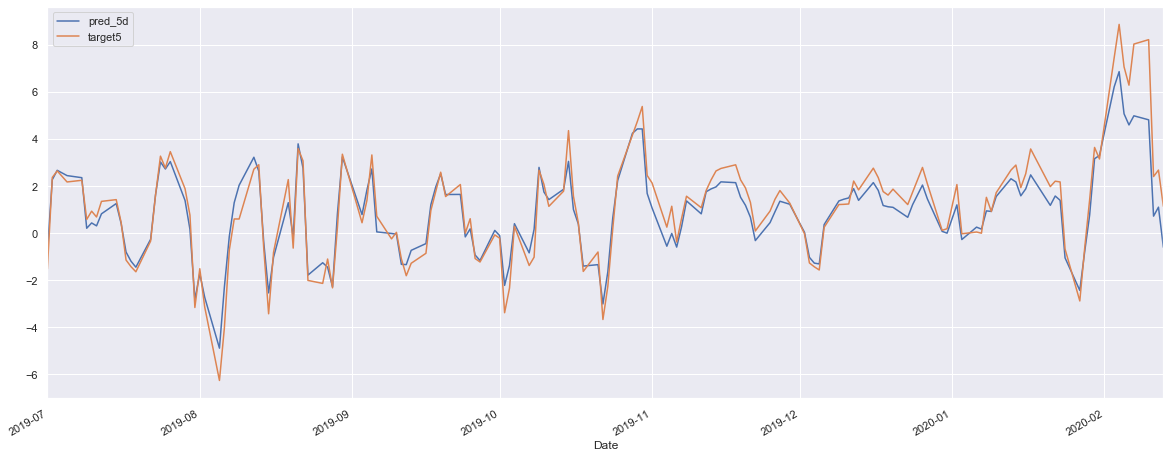

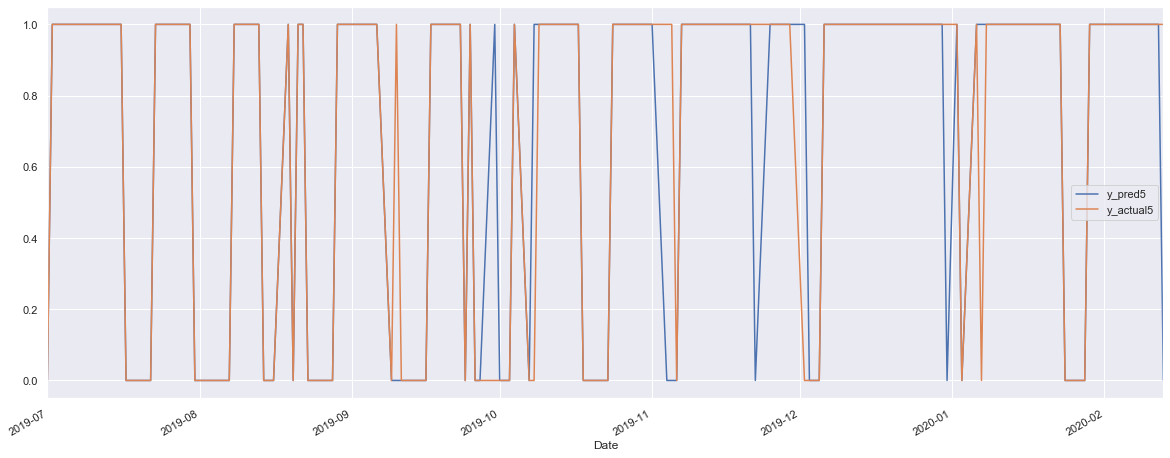

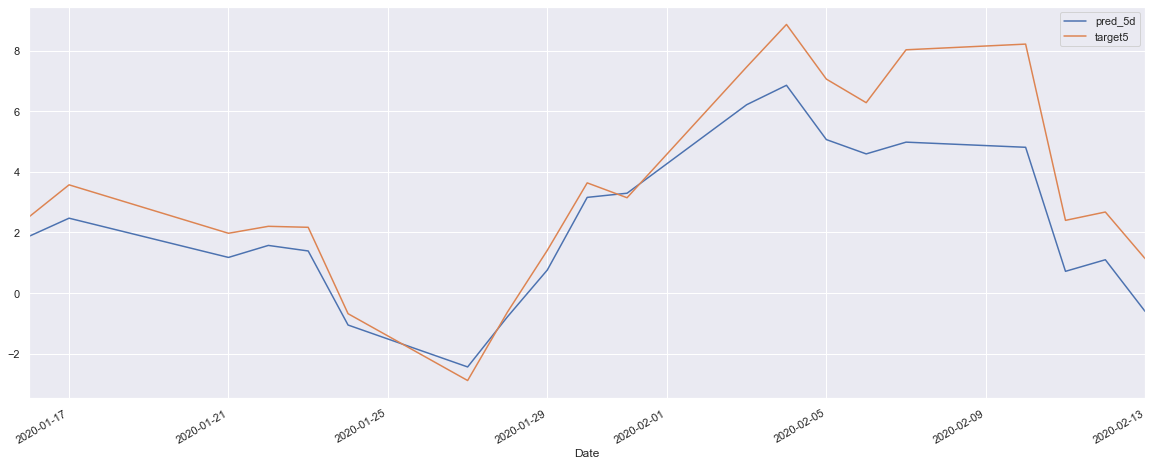

             pred_5d   target5  y_pred5  y_actual5
Date                                              
2020-01-16  1.874394  2.517120      1.0        1.0
2020-01-17  2.469664  3.570100      1.0        1.0
2020-01-21  1.175668  1.972073      1.0        1.0
2020-01-22  1.571687  2.201937      1.0        1.0
2020-01-23  1.388812  2.169384      1.0        1.0
2020-01-24 -1.053957 -0.680026      0.0        0.0
2020-01-27 -2.436576 -2.884500      0.0        0.0
2020-01-28 -0.781159 -0.624625      0.0        0.0
2020-01-29  0.762041  1.412191      1.0        1.0
2020-01-30  3.156265  3.634837      1.0        1.0
2020-01-31  3.293273  3.144692      1.0        1.0
2020-02-03  6.211959  7.456248      1.0        1.0
2020-02-04  6.853673  8.860147      1.0        1.0
2020-02-05  5.062774  7.057843      1.0        1.0
2020-02-06  4.590373  6.279662      1.0        1.0
2020-02-07  4.978165  8.024438      1.0        1.0
2020-02-10  4.808361  8.211951      1.0        1.0
2020-02-11  0.717420  2.398401 

In [4]:
myForecast = DayForecast(ticker="MSFT", period="10y", split_date="2019-07-01", 
                         cut_off_date=None, days=[5], lags=LAGS,
                        verbose=True)
tp_rate = myForecast.forecast(horizon=1, verbose=True)

## Read the Stocks

The stock data is retrieved from EDGAR and contains the stocks owned by Renaissance Technologies (a hedge fund) in NOvember. This was taken from their F-13 filing. Out of some two thousand one hundred (2100) stock one hundred (100) stock stocks have been selected. These stocks have a value for `TICKER`. The other stocks have a null value. The cells below select the stocks for which we do have a `TICKER` symbol. At the the first 5 records in the stock data frame (`sdf`) are shown. 

In [5]:
ls ../data

F13_Renaissance_tech.csv  optimal_params.csv
F13_Renaissance_tech.txt  stocks.csv


In [6]:
sdf = pd.read_csv('../data/stocks.csv')
sdf = sdf.loc[sdf.TICKER > ''].reset_index()
if 'index' in sdf.columns:
    del sdf['index']
sdf.head()

,NAME_OF_ISSUER,CUSIP,VALUE,SHRS_OR_PRN_AMT,SOLE_VOTING_AUTH,NO_VOTING_AUTH,TICKER
0,ADURO BIOTECH INC,00739L101,2902,2738200,2590838,147362,ADRO
1,AGILE THERAPEUTICS INC,00847L100,2876,2427100,2427100,0,AGRX
2,ALCOA CORP,013872106,130047,6479662,5941743,537919,AA
3,ALEXION PHARMACEUTICALS INC,015351109,279096,2849667,2849667,0,ALXN
4,AMERICAN TOWER CORP NEW,03027X100,336963,1523824,1523824,0,AMT


## Select Ten Stocks

To keep things manageable for the Module4 project, ten stocks out of one hundred are selected and worked on. That way we can keep an overview of what we are doihng. When work starts on the final project, we will extend to scope to the one hundred stocks.

In [7]:
idx = sdf.sample(10, random_state=42).index
sdf.loc[idx]

,NAME_OF_ISSUER,CUSIP,VALUE,SHRS_OR_PRN_AMT,SOLE_VOTING_AUTH,NO_VOTING_AUTH,TICKER
83,SPECTRUM PHARMACEUTICALS INC,84763A108,22936,2765017,2747310,17707,SPPI
53,MBIA INC,55262C100,2108,228374,146742,81632,MBI
70,PALO ALTO NETWORKS INC,697435105,1192028,5848150,5622490,225660,PANW
45,HANCOCK WHITNEY CORPORATION,410120109,9687,252962,252962,0,HWC
44,GULF RESOURCES INC,40251W309,1276,1830162,1828362,1800,GURE
39,GRACO INC,384109104,8329,180900,72895,108005,GGG
22,CVR ENERGY INC,12662P108,92673,2104769,2104769,0,CVI
80,SI BONE INC,825704109,723,40900,40900,0,SIBN
10,BMC STK HLDGS INC,05591B109,34168,1305100,1175955,129145,BMCH
0,ADURO BIOTECH INC,00739L101,2902,2738200,2590838,147362,ADRO


## Run Five Day Forecast on Ten Selected Stocks

The cell below runs through the ten selected stocks and produces the same output as we did for Microsoft above. The purpose is to get a sense of how the DayForecast class performs on the ten selected stocks and to visually check the output. Note: generating output for all combinations is simply too much (i.e. 10*4*3=120 different graphs) and is, therefore, not attempted in the notebook.

You can see that the forecasts are doing a pretty good job on the selected ten stocks. The TPR ranges from eighty (80) percent to one hundred (100) percent. Six out of ten stocks have a percentage higher then ninety percent.

This begs the question whether the models are doing too well and whether there is something wrong. This is address below when we run the model over different time periods to expose the models to different stock market conditions. We also extend the period from six monts to twelve months. A longer forecasting period will make it more prone to making errors.

83 SPPI (SPECTRUM PHARMACEUTICALS INC):

5-day TPR:

tn= 72 fn= 13 tp= 70 fp= 3

[[72 13]
 [ 3 70]]

TP/(FN+TP)= 0.8433734939759037 FN+TP= 83


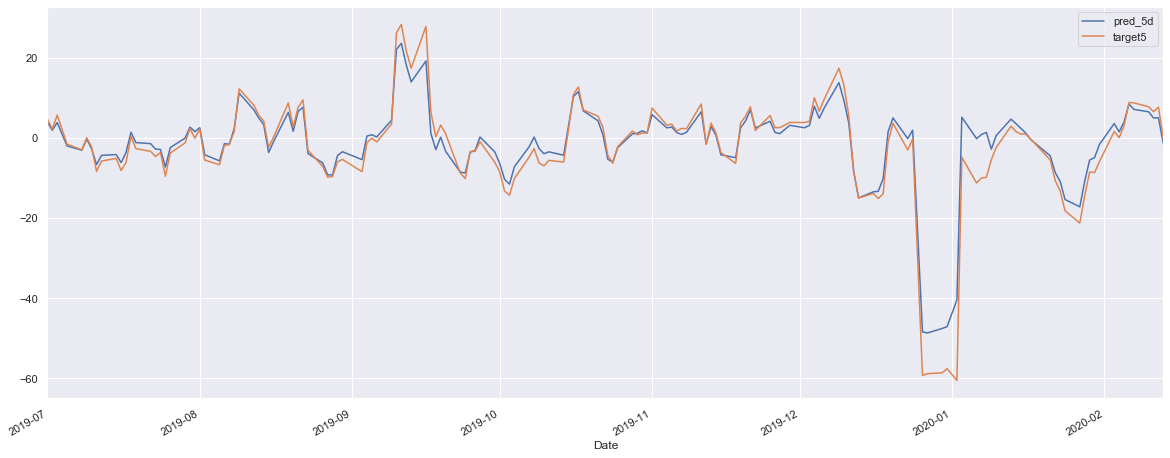

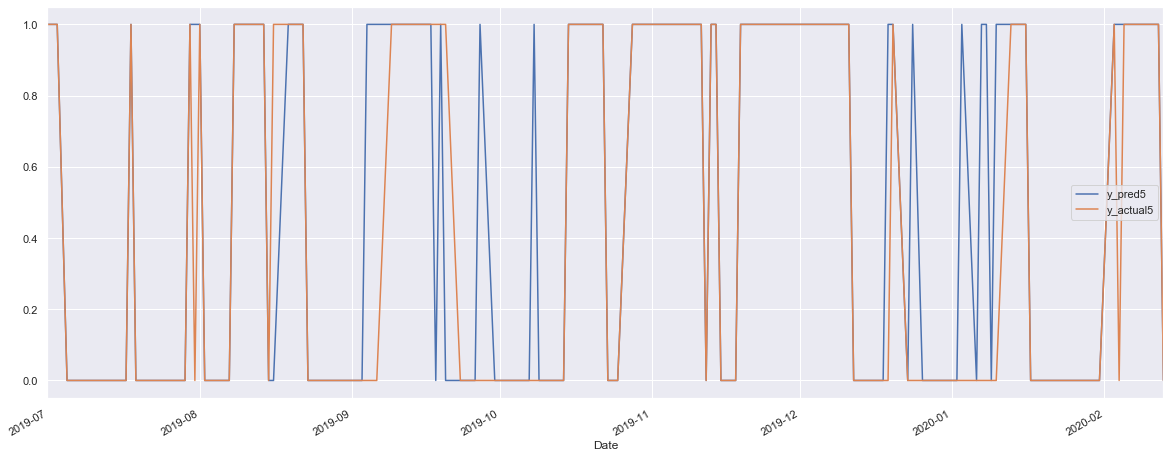

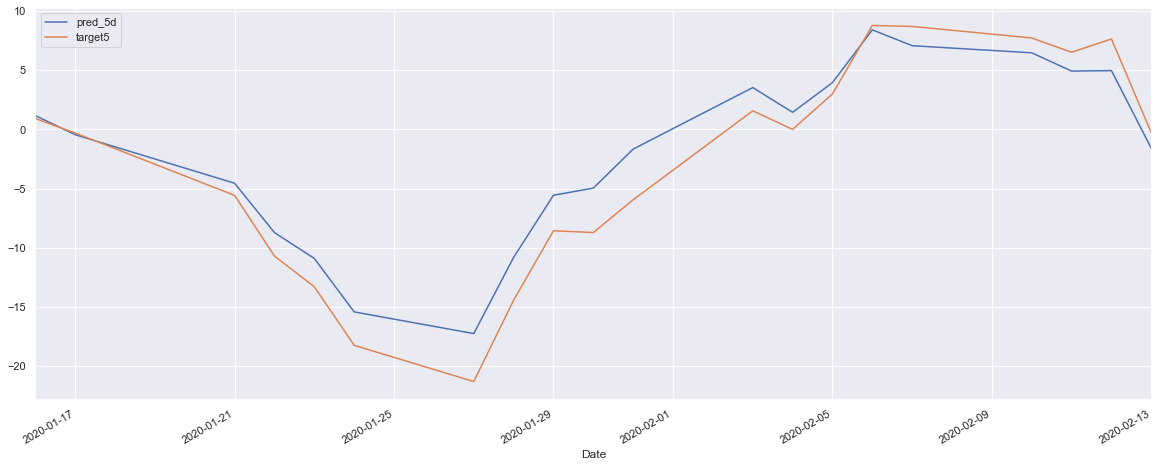

              pred_5d    target5  y_pred5  y_actual5
Date                                                
2020-01-16   1.167543   0.920245      1.0        1.0
2020-01-17  -0.449952  -0.307692      0.0        0.0
2020-01-21  -4.548372  -5.572755      0.0        0.0
2020-01-22  -8.716502 -10.703364      0.0        0.0
2020-01-23 -10.900908 -13.293051      0.0        0.0
2020-01-24 -15.415992 -18.237082      0.0        0.0
2020-01-27 -17.246583 -21.296296      0.0        0.0
2020-01-28 -10.810153 -14.426230      0.0        0.0
2020-01-29  -5.564446  -8.561644      0.0        0.0
2020-01-30  -4.959464  -8.710801      0.0        0.0
2020-01-31  -1.662855  -5.947955      0.0        0.0
2020-02-03   3.530694   1.568627      1.0        1.0
2020-02-04   1.441249   0.000000      1.0        0.0
2020-02-05   3.951271   2.996255      1.0        1.0
2020-02-06   8.407697   8.778626      1.0        1.0
2020-02-07   7.067851   8.695652      1.0        1.0
2020-02-10   6.467953   7.722008      1.0     

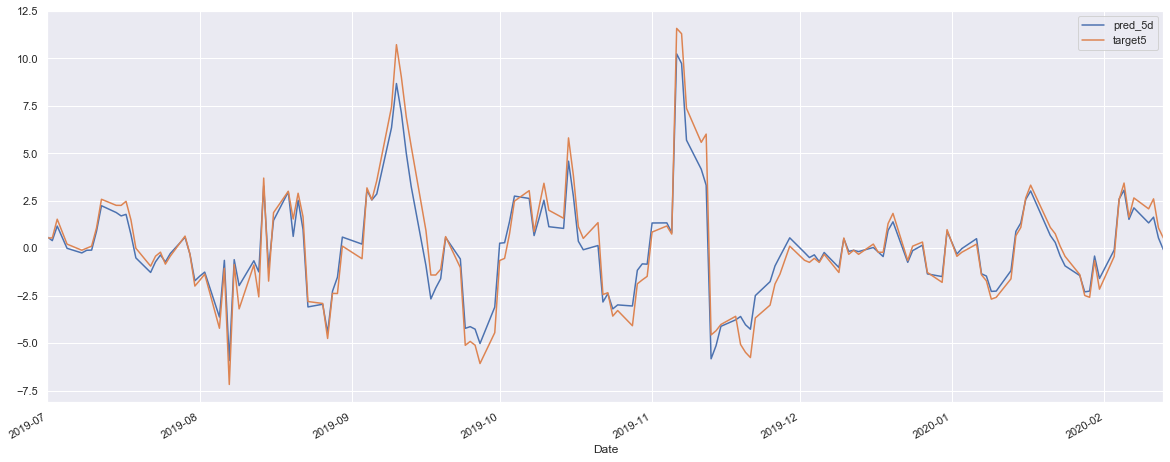

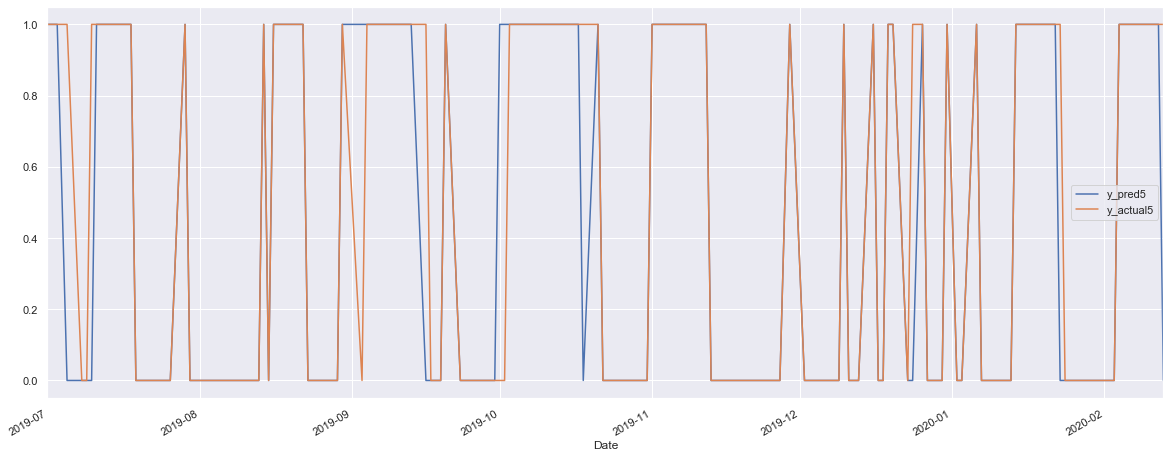

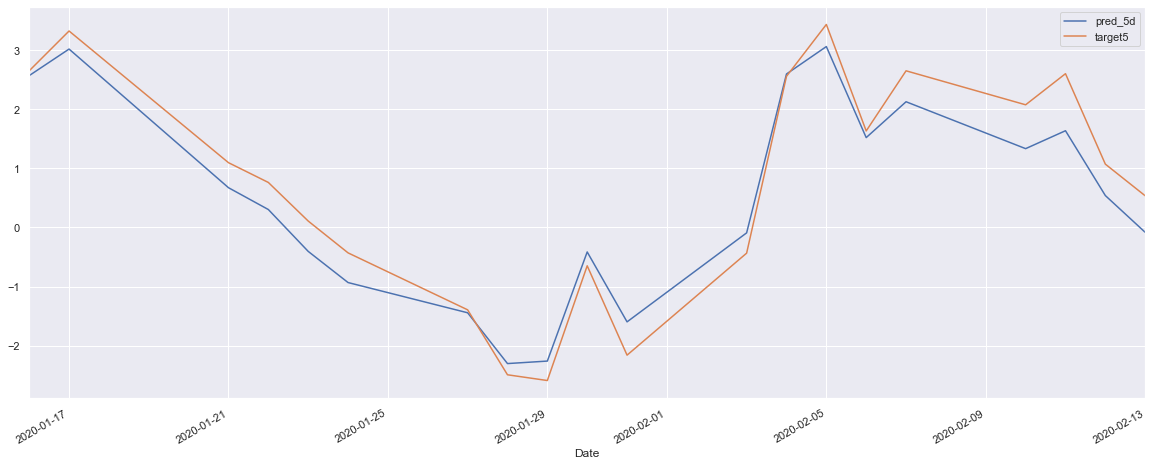

             pred_5d   target5  y_pred5  y_actual5
Date                                              
2020-01-16  2.567829  2.649007      1.0        1.0
2020-01-17  3.016777  3.322259      1.0        1.0
2020-01-21  0.672039  1.095290      1.0        1.0
2020-01-22  0.302955  0.760870      1.0        1.0
2020-01-23 -0.405004  0.108225      0.0        1.0
2020-01-24 -0.932007 -0.430108      0.0        0.0
2020-01-27 -1.443275 -1.393355      0.0        0.0
2020-01-28 -2.302346 -2.491874      0.0        0.0
2020-01-29 -2.260211 -2.588997      0.0        0.0
2020-01-30 -0.414533 -0.648649      0.0        0.0
2020-01-31 -1.596944 -2.159827      0.0        0.0
2020-02-03 -0.091594 -0.434783      0.0        0.0
2020-02-04  2.595167  2.555556      1.0        1.0
2020-02-05  3.058991  3.433001      1.0        1.0
2020-02-06  1.519406  1.632209      1.0        1.0
2020-02-07  2.125637  2.649007      1.0        1.0
2020-02-10  1.332562  2.074236      1.0        1.0
2020-02-11  1.635604  2.600217 

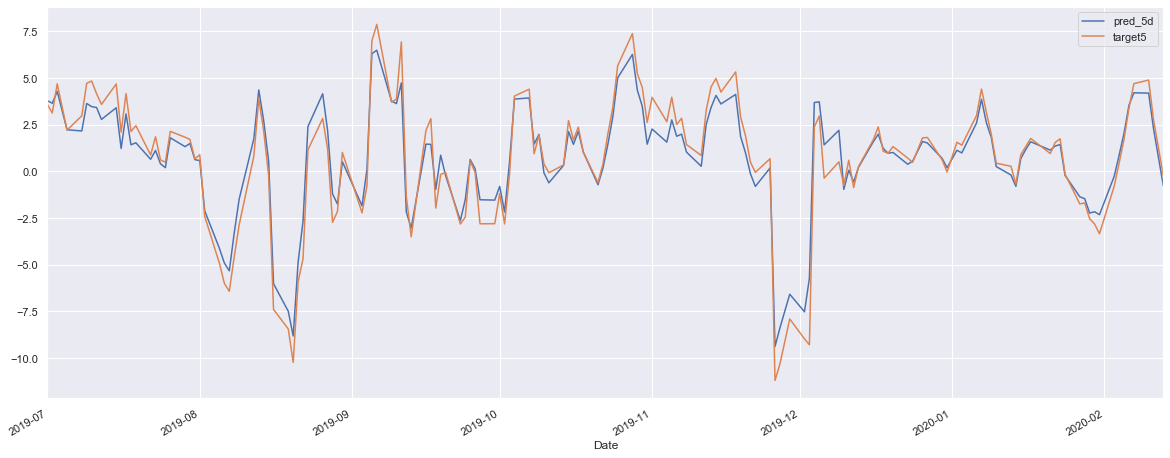

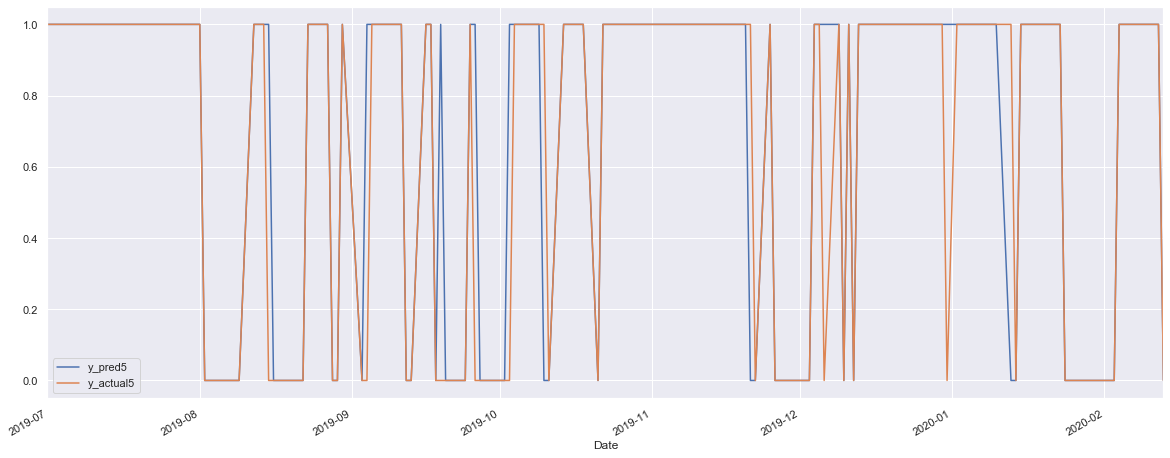

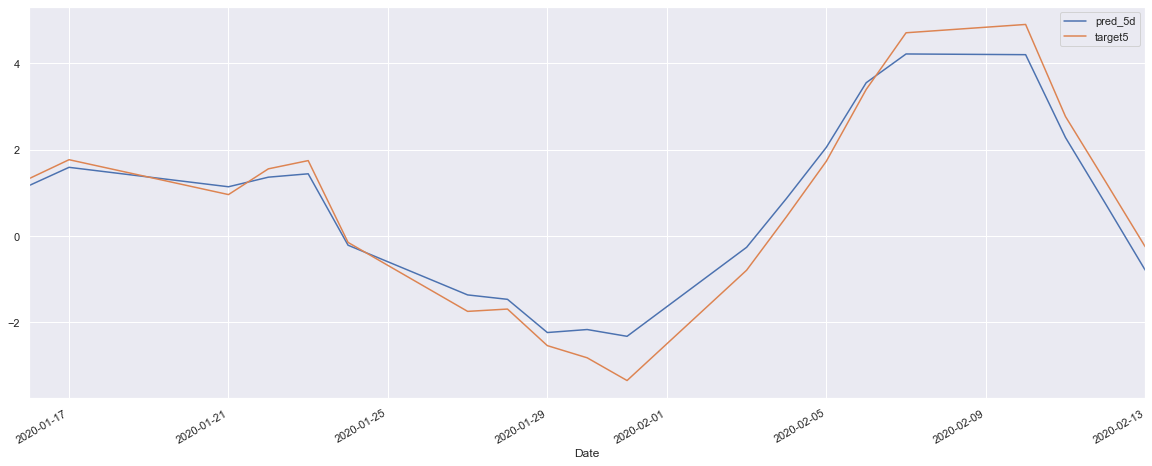

             pred_5d   target5  y_pred5  y_actual5
Date                                              
2020-01-16  1.168620  1.328779      1.0        1.0
2020-01-17  1.589319  1.765670      1.0        1.0
2020-01-21  1.139557  0.958825      1.0        1.0
2020-01-22  1.361346  1.554167      1.0        1.0
2020-01-23  1.439514  1.744911      1.0        1.0
2020-01-24 -0.212652 -0.147990      0.0        0.0
2020-01-27 -1.362412 -1.743297      0.0        0.0
2020-01-28 -1.464487 -1.689759      0.0        0.0
2020-01-29 -2.232687 -2.535593      0.0        0.0
2020-01-30 -2.163329 -2.817477      0.0        0.0
2020-01-31 -2.320177 -3.342939      0.0        0.0
2020-02-03 -0.260492 -0.790414      0.0        0.0
2020-02-04  0.869616  0.447474      1.0        1.0
2020-02-05  2.052029  1.730162      1.0        1.0
2020-02-06  3.546709  3.390756      1.0        1.0
2020-02-07  4.211816  4.702274      1.0        1.0
2020-02-10  4.195515  4.894690      1.0        1.0
2020-02-11  2.278753  2.764478 

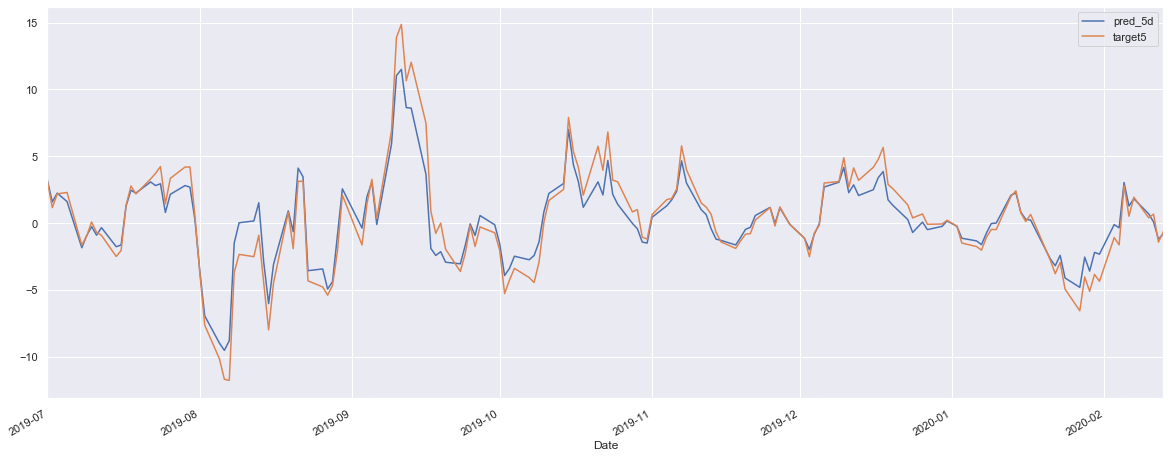

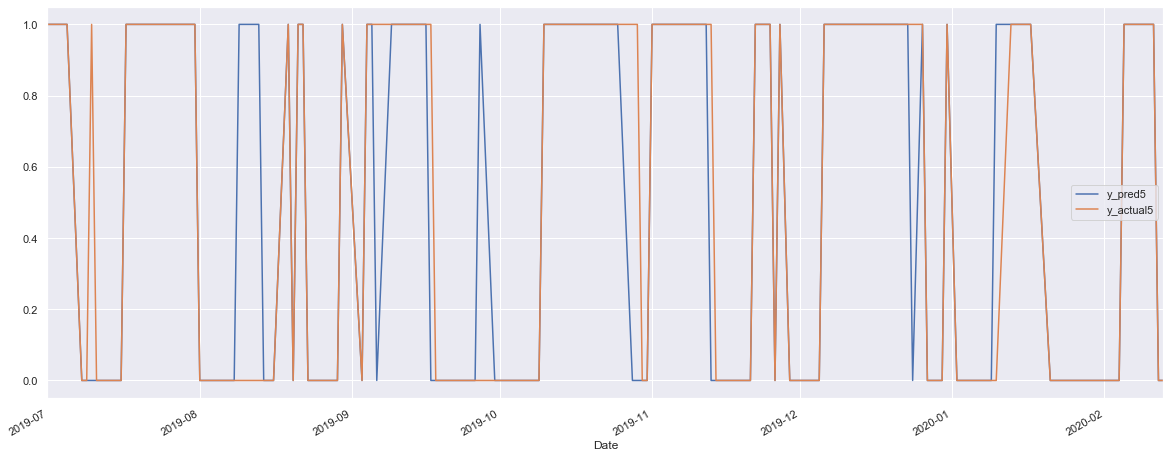

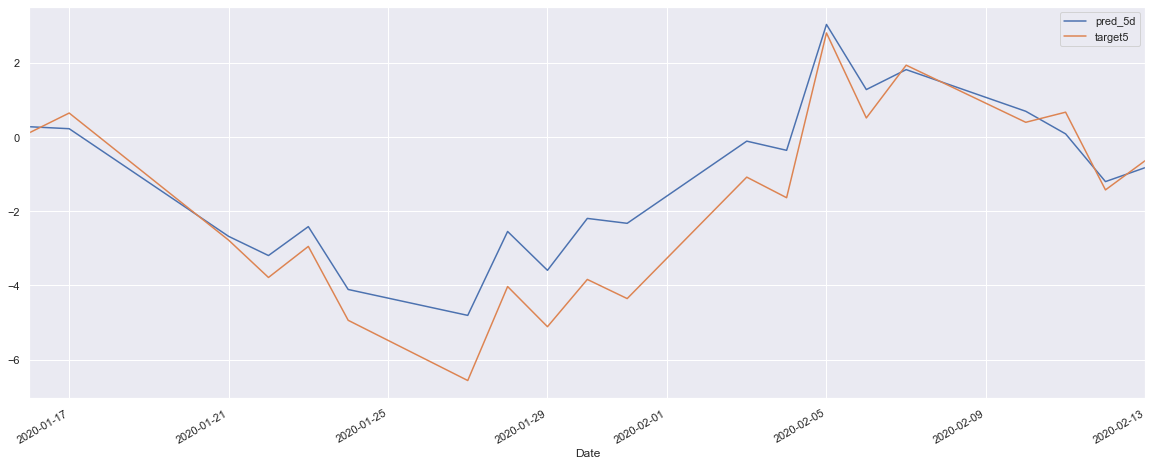

             pred_5d   target5  y_pred5  y_actual5
Date                                              
2020-01-16  0.277867  0.114521      1.0        1.0
2020-01-17  0.224597  0.646950      1.0        1.0
2020-01-21 -2.677899 -2.779676      0.0        0.0
2020-01-22 -3.195378 -3.786848      0.0        0.0
2020-01-23 -2.415523 -2.949246      0.0        0.0
2020-01-24 -4.110381 -4.941661      0.0        0.0
2020-01-27 -4.809095 -6.565657      0.0        0.0
2020-01-28 -2.546191 -4.030935      0.0        0.0
2020-01-29 -3.593894 -5.114306      0.0        0.0
2020-01-30 -2.194354 -3.839812      0.0        0.0
2020-01-31 -2.326658 -4.356197      0.0        0.0
2020-02-03 -0.111036 -1.081081      0.0        0.0
2020-02-04 -0.358412 -1.636142      0.0        0.0
2020-02-05  3.035838  2.806756      1.0        1.0
2020-02-06  1.279978  0.514454      1.0        1.0
2020-02-07  1.817831  1.937594      1.0        1.0
2020-02-10  0.694607  0.397417      1.0        1.0
2020-02-11  0.085192  0.670308 

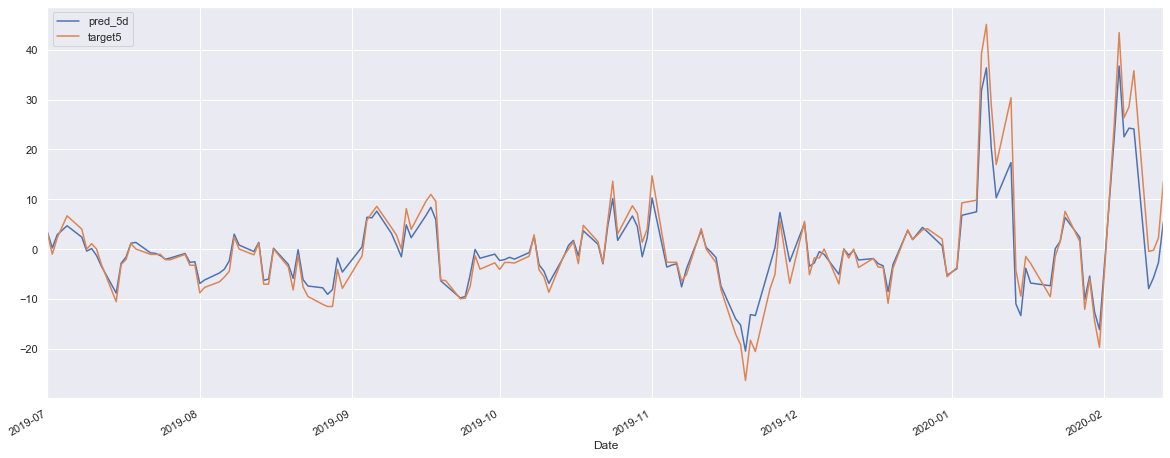

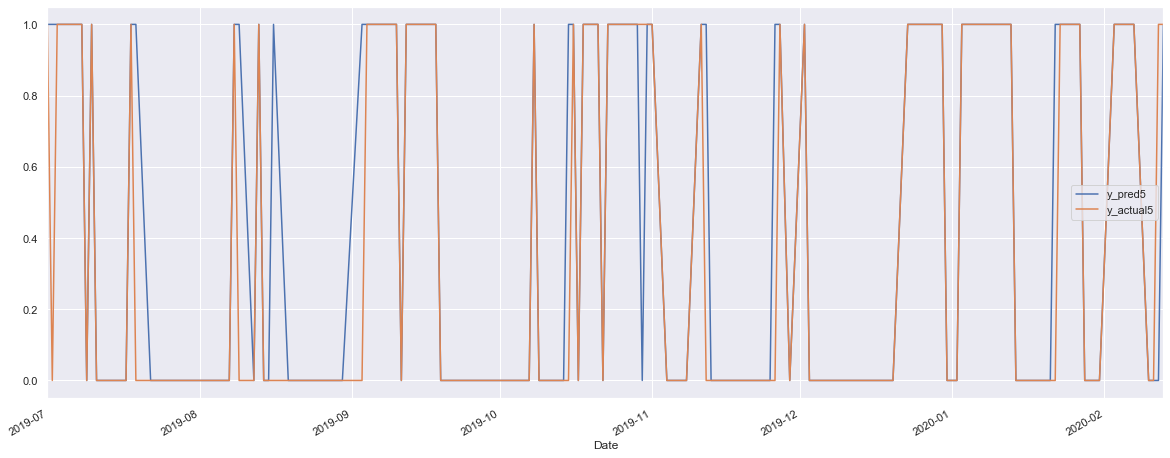

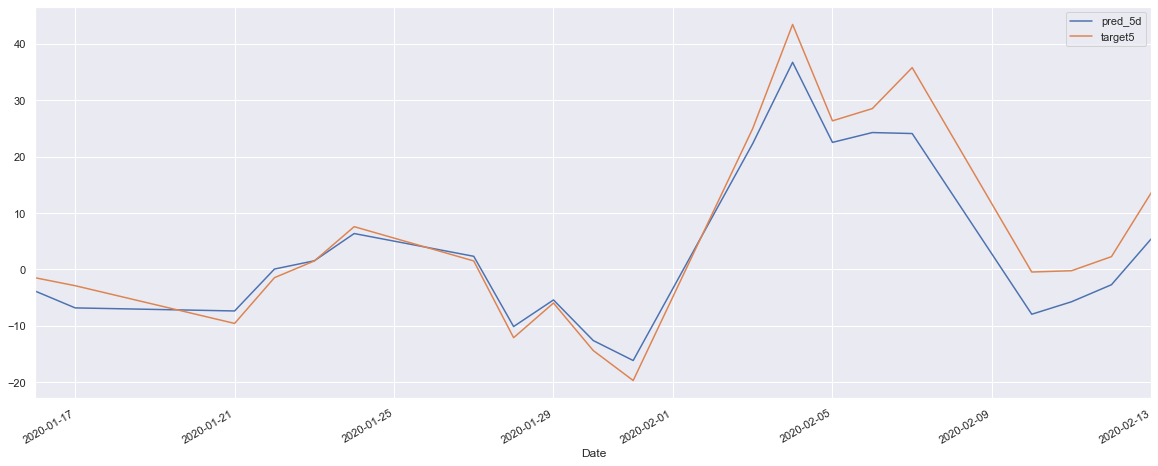

              pred_5d    target5  y_pred5  y_actual5
Date                                                
2020-01-16  -3.862446  -1.492537      0.0        0.0
2020-01-17  -6.834613  -2.898551      0.0        0.0
2020-01-21  -7.377471  -9.589041      0.0        0.0
2020-01-22   0.058129  -1.470588      1.0        0.0
2020-01-23   1.522041   1.492537      1.0        1.0
2020-01-24   6.356257   7.575758      1.0        1.0
2020-01-27   2.319124   1.492537      1.0        1.0
2020-01-28 -10.142025 -12.121212      0.0        0.0
2020-01-29  -5.423841  -5.970149      0.0        0.0
2020-01-30 -12.631863 -14.411765      0.0        0.0
2020-01-31 -16.170761 -19.718310      0.0        0.0
2020-02-03  22.326953  25.000000      1.0        1.0
2020-02-04  36.737475  43.448276      1.0        1.0
2020-02-05  22.526619  26.349206      1.0        1.0
2020-02-06  24.270680  28.522337      1.0        1.0
2020-02-07  24.096531  35.789474      1.0        1.0
2020-02-10  -7.959143  -0.470588      0.0     

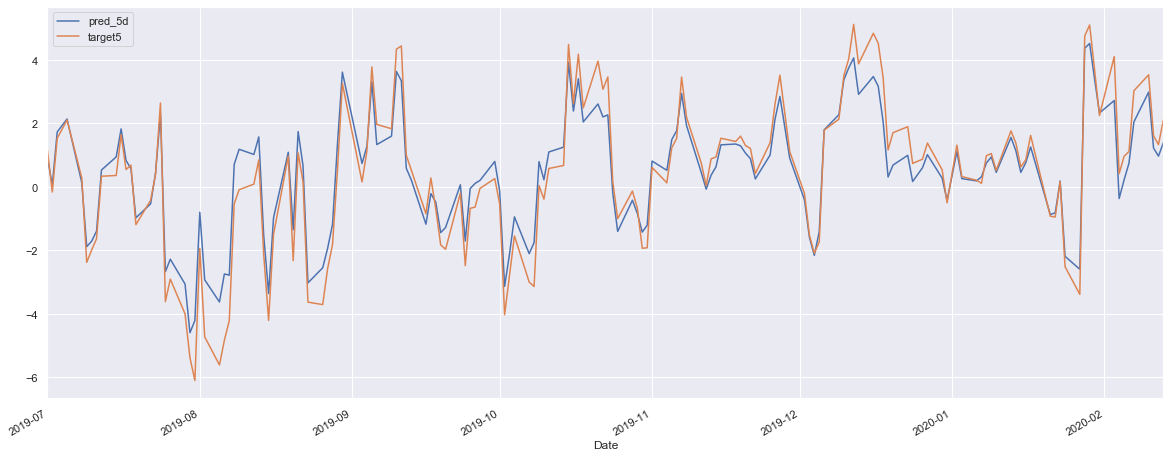

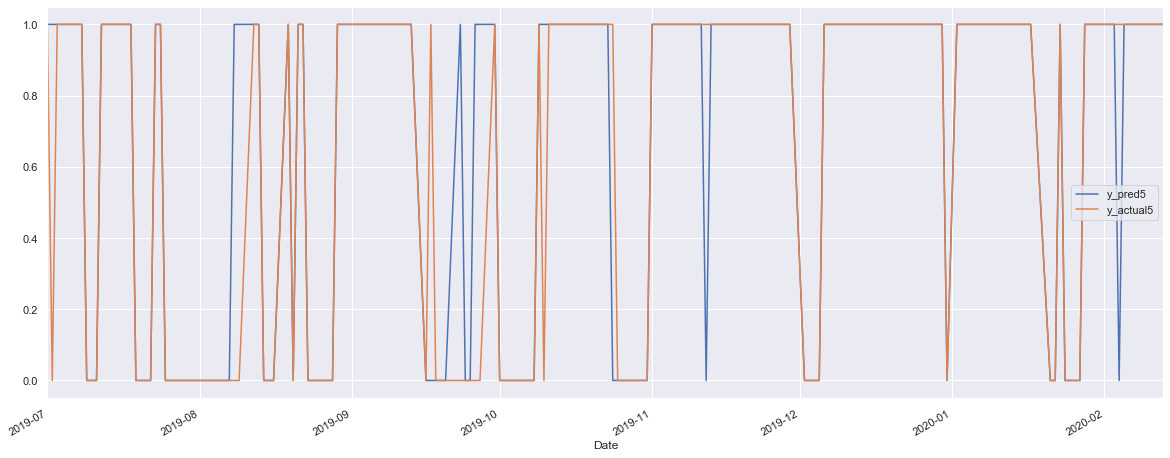

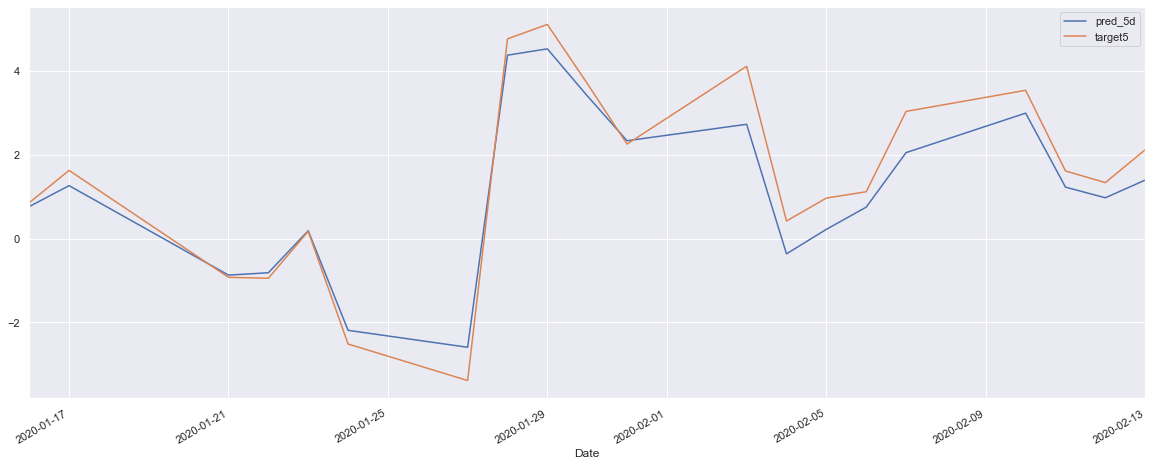

             pred_5d   target5  y_pred5  y_actual5
Date                                              
2020-01-16  0.760784  0.851144      1.0        1.0
2020-01-17  1.260415  1.623687      1.0        1.0
2020-01-21 -0.871236 -0.923831      0.0        0.0
2020-01-22 -0.815373 -0.946253      0.0        0.0
2020-01-23  0.185773  0.170875      1.0        1.0
2020-01-24 -2.187039 -2.513128      0.0        0.0
2020-01-27 -2.591159 -3.383459      0.0        0.0
2020-01-28  4.368994  4.757374      1.0        1.0
2020-01-29  4.519802  5.101261      1.0        1.0
2020-01-30  3.402603  3.695982      1.0        1.0
2020-01-31  2.330428  2.250866      1.0        1.0
2020-02-03  2.722330  4.105058      1.0        1.0
2020-02-04 -0.364718  0.417802      0.0        1.0
2020-02-05  0.218429  0.963461      1.0        1.0
2020-02-06  0.747798  1.114970      1.0        1.0
2020-02-07  2.047122  3.029163      1.0        1.0
2020-02-10  2.987964  3.532050      1.0        1.0
2020-02-11  1.224680  1.609986 

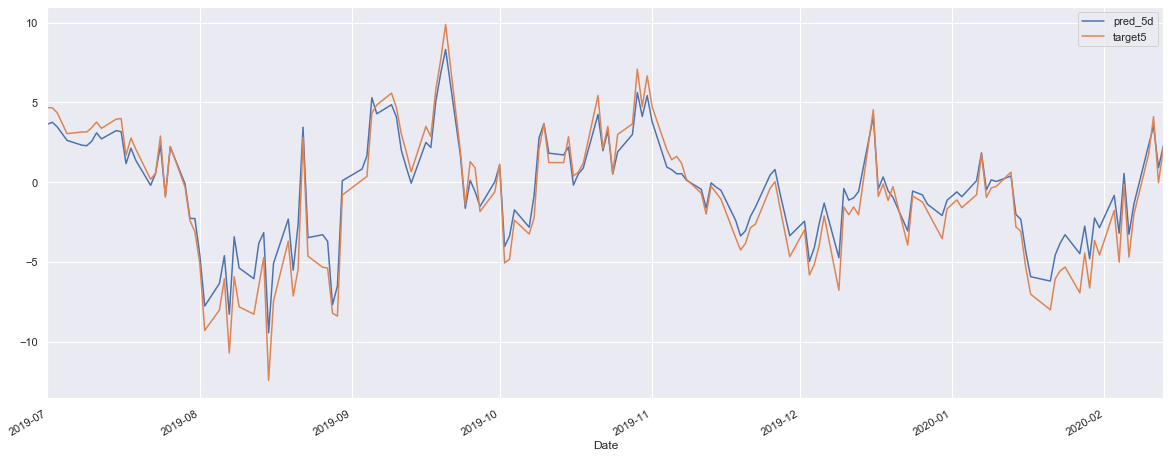

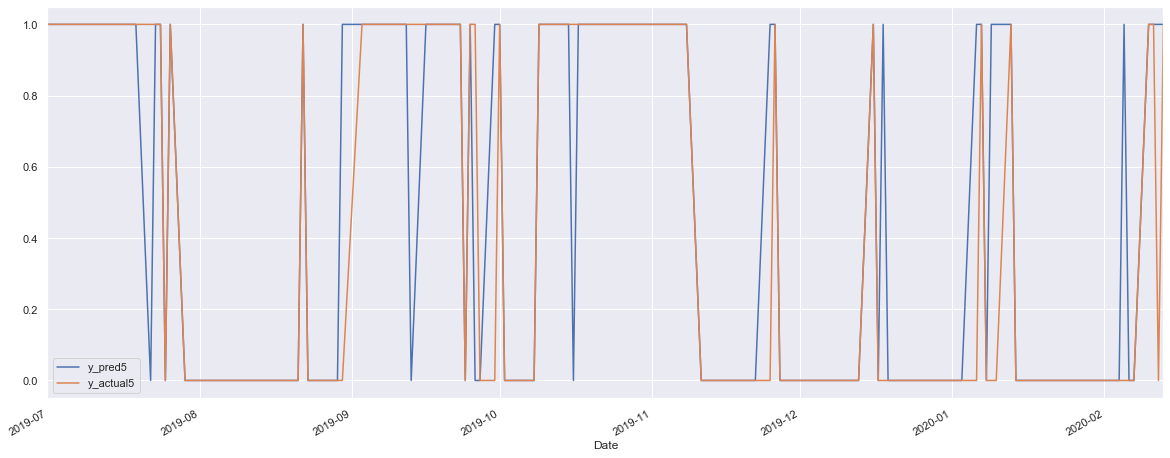

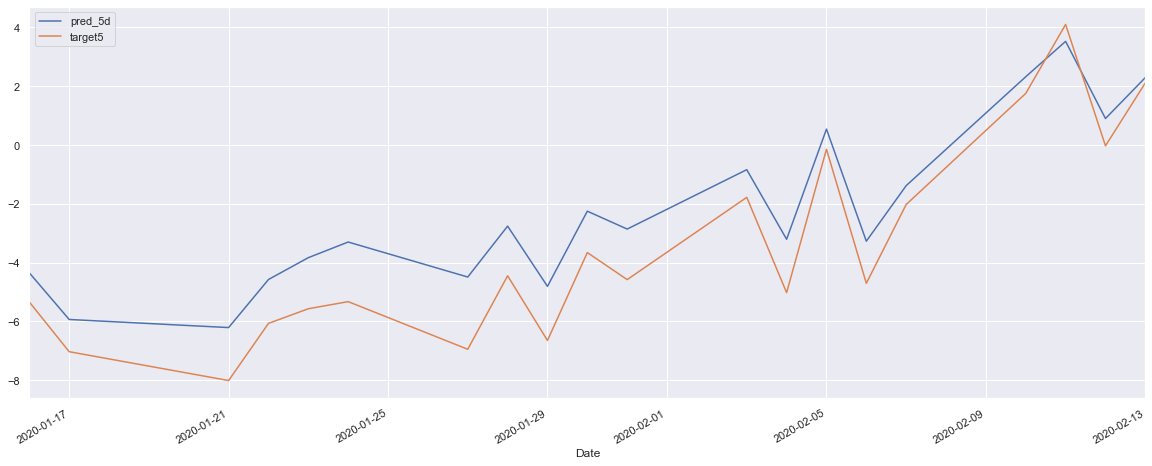

             pred_5d   target5  y_pred5  y_actual5
Date                                              
2020-01-16 -4.345958 -5.337287      0.0        0.0
2020-01-17 -5.931436 -7.027564      0.0        0.0
2020-01-21 -6.206699 -8.006941      0.0        0.0
2020-01-22 -4.573359 -6.065201      0.0        0.0
2020-01-23 -3.830130 -5.567010      0.0        0.0
2020-01-24 -3.298870 -5.324980      0.0        0.0
2020-01-27 -4.488291 -6.944444      0.0        0.0
2020-01-28 -2.758412 -4.446241      0.0        0.0
2020-01-29 -4.805500 -6.645144      0.0        0.0
2020-01-30 -2.250328 -3.657205      0.0        0.0
2020-01-31 -2.858375 -4.576785      0.0        0.0
2020-02-03 -0.839474 -1.779564      0.0        0.0
2020-02-04 -3.205046 -5.019741      0.0        0.0
2020-02-05  0.539463 -0.144092      1.0        0.0
2020-02-06 -3.270794 -4.702550      0.0        0.0
2020-02-07 -1.382324 -2.022537      0.0        0.0
2020-02-10  2.320254  1.753361      1.0        1.0
2020-02-11  3.522611  4.097387 

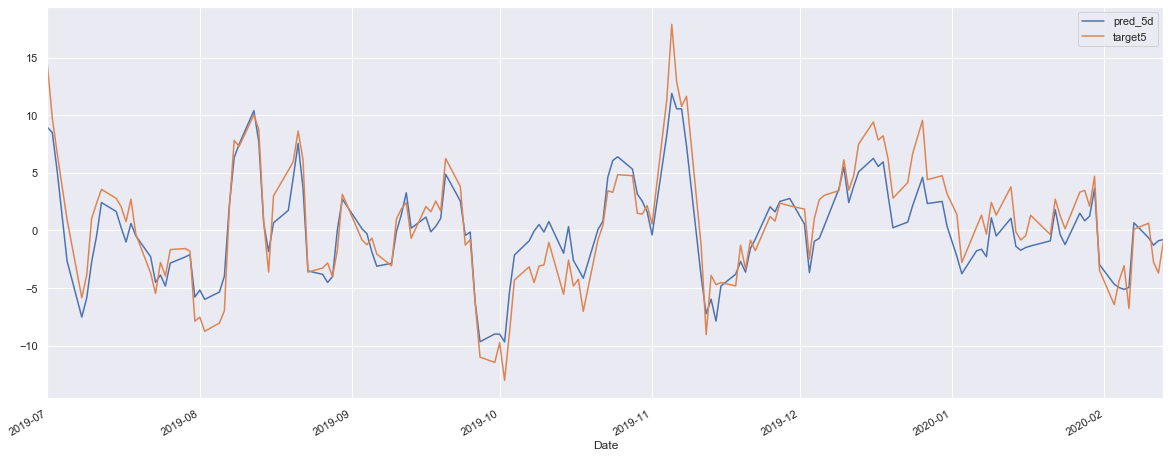

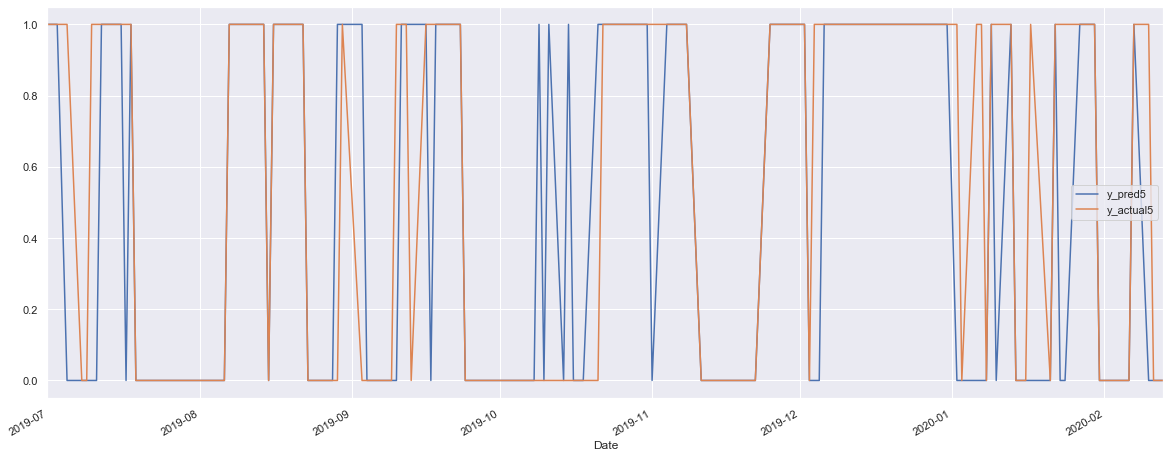

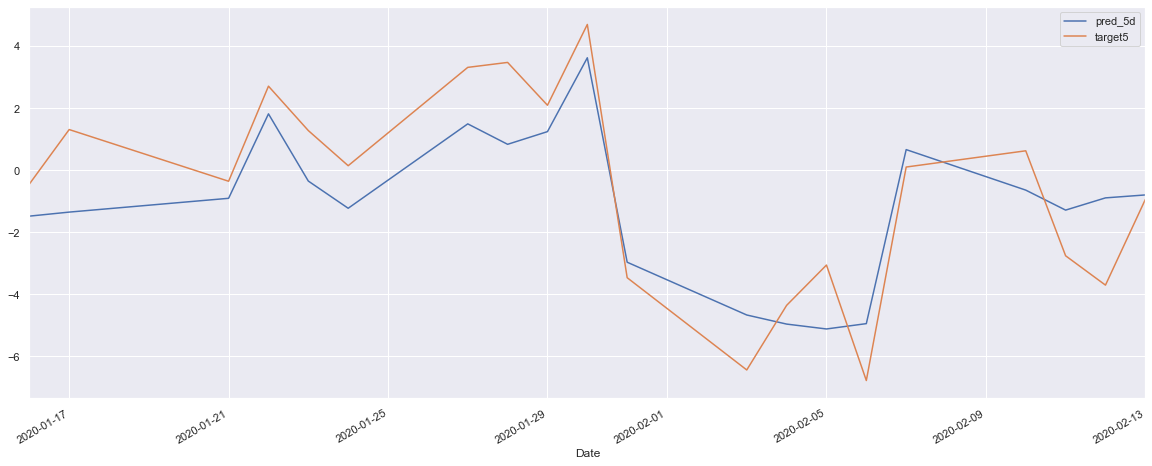

             pred_5d   target5  y_pred5  y_actual5
Date                                              
2020-01-16 -1.489234 -0.455789      0.0        0.0
2020-01-17 -1.358875  1.303538      0.0        1.0
2020-01-21 -0.913831 -0.363802      0.0        0.0
2020-01-22  1.809652  2.702703      1.0        1.0
2020-01-23 -0.358036  1.270588      0.0        1.0
2020-01-24 -1.235003  0.137363      0.0        1.0
2020-01-27  1.486698  3.308824      1.0        1.0
2020-01-28  0.827554  3.468736      1.0        1.0
2020-01-29  1.236909  2.087114      1.0        1.0
2020-01-30  3.618601  4.693309      1.0        1.0
2020-01-31 -2.975336 -3.475080      0.0        0.0
2020-02-03 -4.677484 -6.450178      0.0        0.0
2020-02-04 -4.970548 -4.367005      0.0        0.0
2020-02-05 -5.128064 -3.066667      0.0        0.0
2020-02-06 -4.956093 -6.790945      0.0        0.0
2020-02-07  0.656700  0.094742      1.0        1.0
2020-02-10 -0.649830  0.618165      0.0        1.0
2020-02-11 -1.294649 -2.767528 

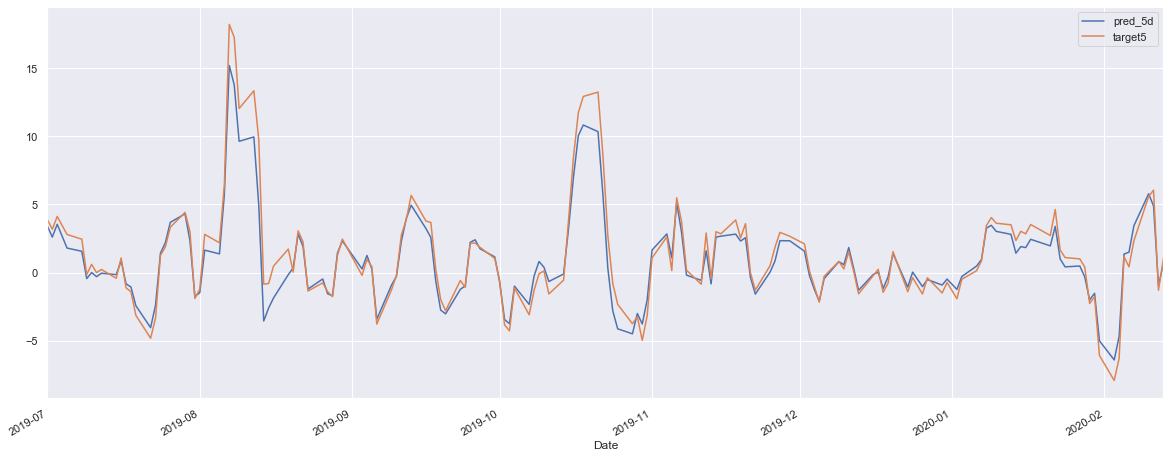

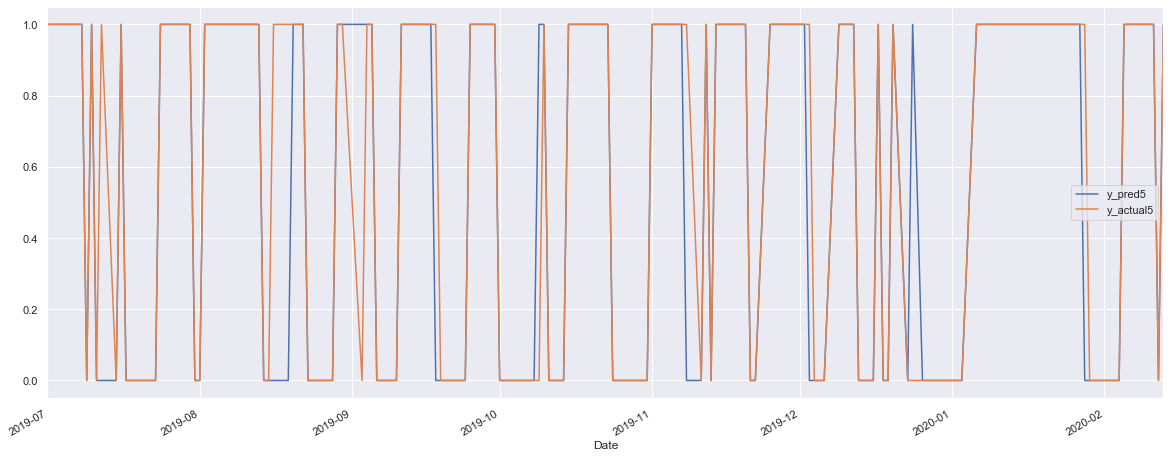

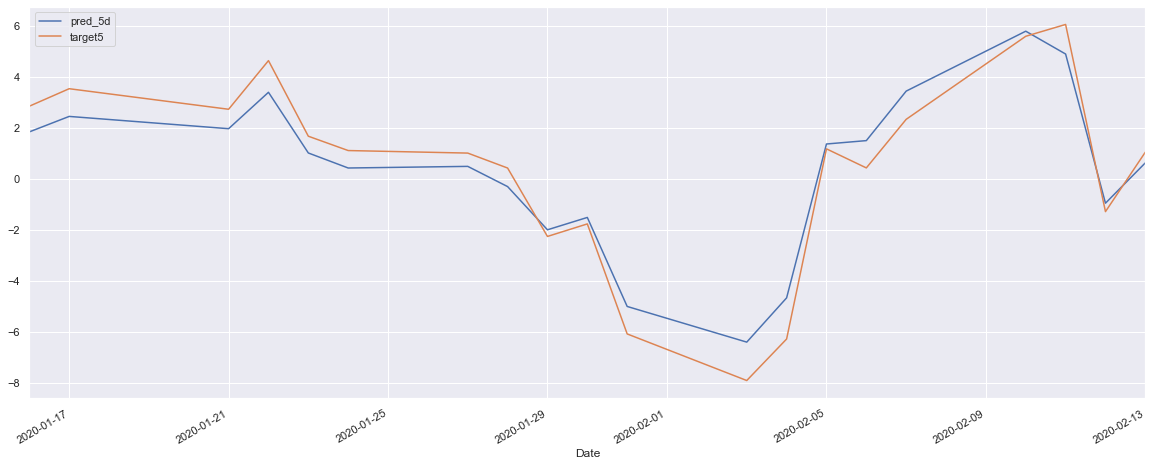

             pred_5d   target5  y_pred5  y_actual5
Date                                              
2020-01-16  1.837254  2.843760      1.0        1.0
2020-01-17  2.443663  3.529412      1.0        1.0
2020-01-21  1.962512  2.724252      1.0        1.0
2020-01-22  3.389071  4.630247      1.0        1.0
2020-01-23  1.010874  1.667757      1.0        1.0
2020-01-24  0.421926  1.106051      1.0        1.0
2020-01-27  0.485634  1.006494      1.0        1.0
2020-01-28 -0.306798  0.420440      0.0        1.0
2020-01-29 -1.999961 -2.260427      0.0        0.0
2020-01-30 -1.515809 -1.769058      0.0        0.0
2020-01-31 -5.004458 -6.081081      0.0        0.0
2020-02-03 -6.402222 -7.907425      0.0        0.0
2020-02-04 -4.667945 -6.280193      0.0        0.0
2020-02-05  1.362713  1.172638      1.0        1.0
2020-02-06  1.495254  0.425671      1.0        1.0
2020-02-07  3.435334  2.329565      1.0        1.0
2020-02-10  5.783904  5.584642      1.0        1.0
2020-02-11  4.888884  6.048110 

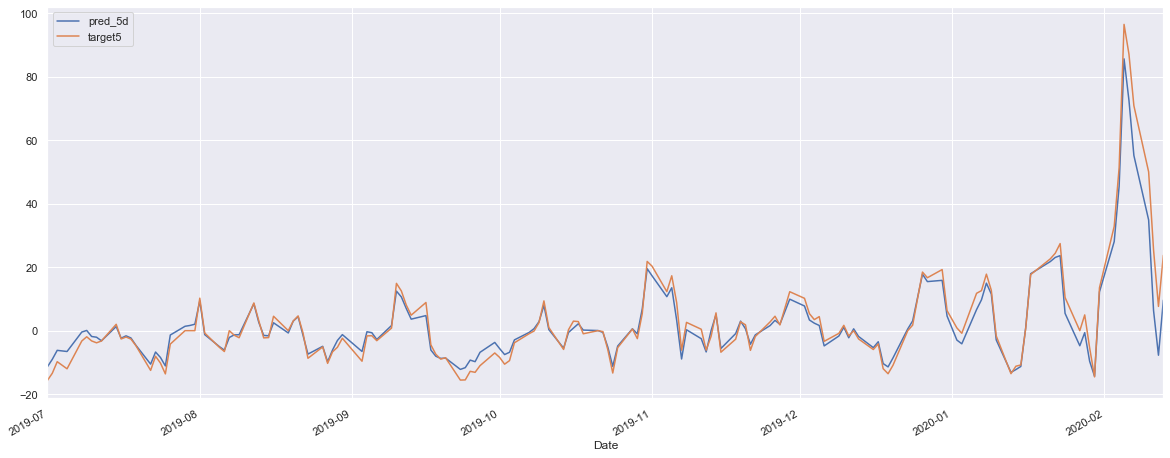

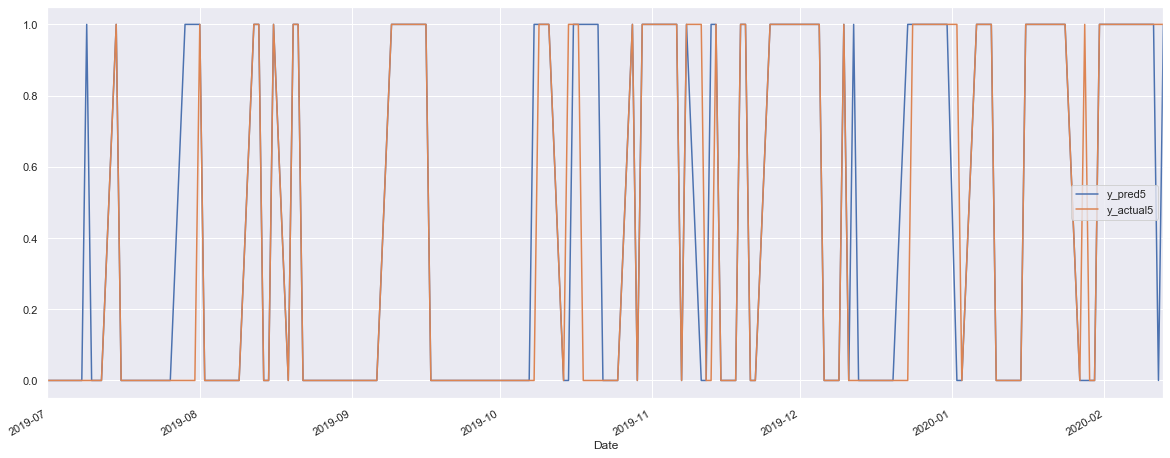

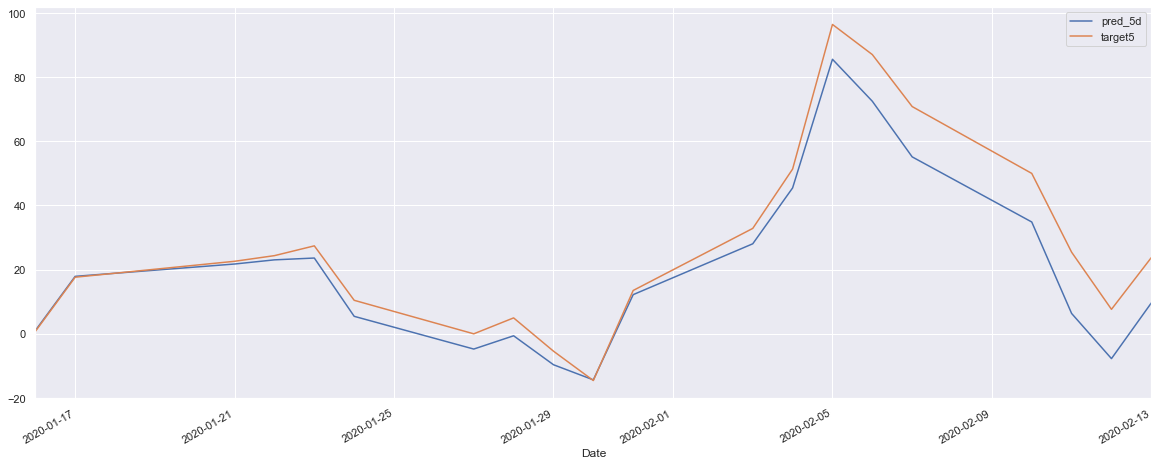

              pred_5d    target5  y_pred5  y_actual5
Date                                                
2020-01-16   1.011080   0.751880      1.0        1.0
2020-01-17  17.916212  17.647059      1.0        1.0
2020-01-21  21.758568  22.608696      1.0        1.0
2020-01-22  23.055482  24.369748      1.0        1.0
2020-01-23  23.621025  27.419355      1.0        1.0
2020-01-24   5.453846  10.447761      1.0        1.0
2020-01-27  -4.748536   0.000000      0.0        0.0
2020-01-28  -0.610308   4.964539      0.0        1.0
2020-01-29  -9.633203  -5.405405      0.0        0.0
2020-01-30 -14.353233 -14.556962      0.0        0.0
2020-01-31  12.212032  13.513514      1.0        1.0
2020-02-03  28.060521  32.857143      1.0        1.0
2020-02-04  45.478674  51.351351      1.0        1.0
2020-02-05  85.575657  96.428571      1.0        1.0
2020-02-06  72.491092  87.037037      1.0        1.0
2020-02-07  55.150994  70.833333      1.0        1.0
2020-02-10  34.856141  50.000000      1.0     

In [8]:
for i, ticker in zip(idx, sdf['TICKER'].loc[idx]):
    name_of_issuer = sdf['NAME_OF_ISSUER'].loc[i]
    print(f"{i} {ticker} ({name_of_issuer}):"); print("="*(7+len(ticker)+len(name_of_issuer)))
    print('')
    
    myForecast = DayForecast(ticker=ticker, period="10y", split_date="2019-07-01", 
                             cut_off_date=None, days=[5], lags=LAGS,
                            verbose=False)
    tp_rate = myForecast.forecast(horizon=1, verbose=True)
    print('')

## Find Optimal Parameters for Selected Ten Stocks for 'n' Day Forecast

The cell below calls the optimize function in `frankie.py`. It tries different combinations for period and lags. The output shows the parameters for the optimal models. The optimal parameters are stored in the stock data frame`sdf`. At the end the stock data frame is printed for reference.

In [9]:
optimize(sdf, idx)

83 SPPI (SPECTRUM PHARMACEUTICALS INC):

3-day forecast:
best_period= 3y
best_lags= [1, 3, 5]
best_tp_rate= 0.9114

5-day forecast:
best_period= 3y
best_lags= [1, 3]
best_tp_rate= 0.9221

8-day forecast:
best_period= 3y
best_lags= [1, 3, 5, 10]
best_tp_rate= 1.0

10-day forecast:
best_period= 10y
best_lags= [1, 3, 5]
best_tp_rate= 0.9718

53 MBI (MBIA INC):

3-day forecast:
best_period= 8y
best_lags= [1, 3]
best_tp_rate= 0.8824

5-day forecast:
best_period= 15y
best_lags= [1, 3]
best_tp_rate= 0.9722

8-day forecast:
best_period= 8y
best_lags= [1, 3]
best_tp_rate= 1.0

10-day forecast:
best_period= 15y
best_lags= [1, 3]
best_tp_rate= 0.9863

70 PANW (PALO ALTO NETWORKS INC):

3-day forecast:
best_period= 3y
best_lags= [1, 3, 5, 10, 20, 30]
best_tp_rate= 0.949

5-day forecast:
best_period= 3y
best_lags= [1, 3]
best_tp_rate= 0.973

8-day forecast:
best_period= 15y
best_lags= [1, 3]
best_tp_rate= 0.9907

10-day forecast:
best_period= 3y
best_lags= [1, 3]
best_tp_rate= 1.0

45 HWC (HANCOCK 

In [10]:
gc.collect()

20

## Determine Naive 'True Positive Rate' 

The optimal TPR for each of the stocks is meaningless without knowing the naive basline. The naive baseline for each of the ten stock is determined by calling `baseline()`. The period is 2019-07-01 to 2020-02-07 to allow comparison with the optimal parameters.

In [11]:
baseline(sdf, idx, '2019-07-01', '2020-02-09')
gc.collect()

83 SPPI (SPECTRUM PHARMACEUTICALS INC):


period: 2019-07-01 - 2020-02-09
3-day forecast naive TPR: 0.4675 (=72/154)
5-day forecast naive TPR: 0.4351 (=67/154)
8-day forecast naive TPR: 0.3961 (=61/154)
10-day forecast naive TPR: 0.3831 (=59/154)

53 MBI (MBIA INC):


period: 2019-07-01 - 2020-02-09
3-day forecast naive TPR: 0.4091 (=63/154)
5-day forecast naive TPR: 0.4286 (=66/154)
8-day forecast naive TPR: 0.4026 (=62/154)
10-day forecast naive TPR: 0.3831 (=59/154)

70 PANW (PALO ALTO NETWORKS INC):


period: 2019-07-01 - 2020-02-09
3-day forecast naive TPR: 0.6234 (=96/154)
5-day forecast naive TPR: 0.6494 (=100/154)
8-day forecast naive TPR: 0.6299 (=97/154)
10-day forecast naive TPR: 0.5974 (=92/154)

45 HWC (HANCOCK WHITNEY CORPORATION):


period: 2019-07-01 - 2020-02-09
3-day forecast naive TPR: 0.487 (=75/154)
5-day forecast naive TPR: 0.487 (=75/154)
8-day forecast naive TPR: 0.474 (=73/154)
10-day forecast naive TPR: 0.4545 (=70/154)

44 GURE (GULF RESOURCES INC):


period:

0

## TPR Cross Validation

The cell below determines the TPR cross validation by calculating the TPR for each stock over different periods. It gicves a sense of how well the "optimal" model for each stock performs under different market conditions. The `cross_val;_tpr()` functiosn goes back until 2005. This is done to ensure that the stock market crash of 2007 - 2008 is included in the conditions. Note: this only works for stocks listed on the stock market at the time. Some of the stocvks do not go that far back.

In [12]:
cross_val_tpr(sdf, idx)
gc.collect()

83 SPPI (SPECTRUM PHARMACEUTICALS INC):

3-day forecast: [0.8841, 0.8722, 0.9286, 0.8676, 0.8382, 0.8815, 0.8611, 0.8621, 0.9221, 0.9394, 0.916, 0.8417, 0.9412, 0.8837]
   min=0.8382 max=0.9412
   mean=0.8885  std=0.033618927643789716

5-day forecast: [0.9394, 0.9621, 0.9669, 0.9621, 0.9441, 0.9457, 0.9718, 0.9648, 0.9747, 0.9857, 0.9857, 0.9016, 0.9853, 0.9516]
   min=0.9016 max=0.9857
   mean=0.9601  std=0.021971555126887986

8-day forecast: [0.9841, 0.9781, 0.9595, 0.9919, 0.9424, 0.9606, 0.9338, 0.9521, 0.9693, 0.9655, 0.953, 0.9099, 0.9789, 0.9837]
   min=0.9099 max=0.9919
   mean=0.9616  std=0.021618062175988342

10-day forecast: [0.9762, 0.9706, 0.9837, 0.9762, 0.9643, 0.984, 0.9533, 0.9632, 0.9765, 0.9688, 0.9732, 0.92, 0.9929, 0.9927]
   min=0.92 max=0.9929
   mean=0.9711  std=0.01771762065381954

53 MBI (MBIA INC):

3-day forecast: [0.8872, 0.9379, 0.856, 0.8889, 0.8421, 0.92, 0.8308, 0.8438, 0.8295, 0.8794, 0.8571, 0.8017, 0.7154, 0.844]
   min=0.7154 max=0.9379
   mean=0.85

0

## Locate Coefficients ARX Model

The cells below identify where the coefficients are stored in an ARX model. To calculate one day forward, we will need to extract these parameters and then calculate the 'n' day forecast one day ahead. The first cell builds a model and shows the summary. The next cell lists the coefficients that are provided in the summary. 

The formulas below show how to calculate the next day forecasts: 

$$ r_{t} = \mu_{t} + \epsilon_{t} $$

$$ \mu_{t} = Const + Close[1] \cdot \mu_{t-1} + Close[3] \cdot \mu_{t-3} 
             + Close[5] \cdot \mu_{t-5} + Close[10] \cdot \mu_{t-10}
$$

$$ \epsilon_{t} = \sigma_{t} \cdot e_{t}
$$

$$ e_{t} = T(nu)
$$

$$ \sigma_{t} = omega + alpha[1] \cdot \left| \epsilon_{t-1} \right| +
    gamma[1] \cdot \left| \epsilon_{t-1} \right| \cdot I_{[\epsilon_{t-1} < 0]} +
    beta[1] \cdot \sigma_{t-1}
$$

Note that the  names like omega refer to the values provided in the ARX summary.

The cell below creates a test three day forecast for Microsoft. It is used as a basis for developing the forecasting code.

In [13]:
myForecast = DayForecast(ticker="MSFT", period="10y", 
                split_date="2019-07-01", cut_off_date=None,
                days=[3], lags=[1,3, 5,10], verbose=True)

                           AR - TARCH/ZARCH Model Results                           
Dep. Variable:                        Close   R-squared:                       0.500
Mean Model:                              AR   Adj. R-squared:                  0.499
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -4375.21
Distribution:      Standardized Student's t   AIC:                           8770.42
Method:                  Maximum Likelihood   BIC:                           8828.03
                                              No. Observations:                 2346
Date:                      Thu, Feb 13 2020   Df Residuals:                     2336
Time:                              10:25:03   Df Model:                           10
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

In the summary above we can see the parameters for the different models and their values. The cell below shows how to retrieve them from the model.

In [14]:
params = myForecast.res_dict['3d'].params
params

Const        0.138691
Close[1]     0.743992
Close[3]    -0.305030
Close[5]     0.062872
Close[10]    0.006882
omega        0.097744
alpha[1]     0.092182
gamma[1]     0.074028
beta[1]      0.844376
nu           5.758948
Name: params, dtype: float64

Call the forecast method to create the dataframe with the forecasted percentage change values. The forecasted values are stored in `forecast_df` data frame. 

In [15]:
tp_rate, forecast_df = myForecast.forecast(horizon=1, verbose=False)
forecast_df.tail(10)

,pred_3d,target3,y_pred3,y_actual3
Date,,,,
2020-01-31,1.620387,2.882872,1.0,1.0
2020-02-03,0.938555,3.772911,1.0,1.0
2020-02-04,2.532276,4.248177,1.0,1.0
2020-02-05,3.619358,5.680550,1.0,1.0
2020-02-06,2.964597,5.304507,1.0,1.0
2020-02-07,0.186171,2.093049,1.0,1.0
2020-02-10,2.421863,4.891606,1.0,1.0
2020-02-11,0.198084,0.441104,1.0,1.0
2020-02-12,-0.643604,0.445919,0.0,1.0


Extract the coefficients for the percentage change and store them in a list so we can use them later for calculating mu_t for all forecasted values. Note that we set the day to three. The final version will have to loop through all the days in the day_list. To simplify things this is ignored for now.

In [16]:
day = 3
forecast_df['mu_t_'+str(day)+"d"] = 0
mu_coefs = []
mu_lags = [0]

mu_coefs.append(float(params[params.index == 'Const']))

for arg_name in params.index:
    if 'Close' in arg_name:
        index = int(arg_name[6:-1])
        mu_lags.append(-index)
        
        close_coef = float(params[params.index == arg_name])
        mu_coefs.append(close_coef)

max_lag = abs(min(mu_lags))

print("mu_coefs=", mu_coefs)
print("mu_lags=", mu_lags)
print("max_lag=", max_lag)

mu_coefs= [0.13869142702503004, 0.7439916392397623, -0.30503005835826097, 0.0628721151040831, 0.006881591649165276]
mu_lags= [0, -1, -3, -5, -10]
max_lag= 10


In [17]:
sigma_names = ['omega', 'alpha[1]', 'gamma[1]', 'beta[1]']
sigma_coefs = []
for arg_name in sigma_names:
    sigma_coef = float(params[params.index == arg_name])
    sigma_coefs.append(sigma_coef)

print("sigma_coefs=", sigma_coefs)

sigma_coefs= [0.09774444414589906, 0.09218225028686618, 0.07402806158267554, 0.8443755245726013]


In [18]:
nu = float(params[params.index == "nu"])
nu

5.758947552136246

Create a local dataframe to avoid messing up the data frame used by ARX. We cut off the forecasted rows to avoid problems and leaking information. As the hist data frame does not contain the percentage column we need to recreate it again. This is done in the cell below as well. `myForecast.split_date` is the date from which the forecasting starts.

In [19]:
pred_col     = "pred_"     +str(day)+"d"
sigma_col    = "sigma_t_"  +str(day)+"d"
mu_col       = "mu_t_"     +str(day)+"d"
e_col        = "e_t_"      +str(day)+"d"
eps_col      = "eps_t_"    +str(day)+"d"
forecast_col = "forecast_" +str(day)+"d"

In [20]:
hist            = myForecast.hist.loc[myForecast.hist.index < myForecast.split_date]
hist[pred_col]  = 100*hist.Close.pct_change(day).dropna()
hist[sigma_col] = hist[pred_col].rolling(max_lag).std()
hist[mu_col]    = hist[pred_col].rolling(max_lag).mean()
hist            = hist.dropna()
hist.tail(max_lag)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Test,pred_3d,sigma_t_3d,mu_t_3d
Date,,,,,,,,,,,
2019-06-17,131.74,132.83,131.64,131.96,14517800,0.0,0,0,1.033612,3.075642,2.292129
2019-06-18,133.29,134.33,132.68,134.25,25934500,0.0,0,0,2.145629,2.677998,2.711672
2019-06-19,134.10,135.02,132.91,134.78,23744400,0.0,0,0,2.447552,2.658836,2.782232
2019-06-20,136.53,136.74,134.81,136.03,33042600,0.0,0,0,3.084268,2.296315,2.425336
2019-06-21,135.67,136.81,135.55,136.05,36727900,0.0,0,0,1.340782,1.749190,1.889913
2019-06-24,136.08,137.47,136.08,136.86,20628800,0.0,0,0,1.543256,1.248645,1.506596
2019-06-25,136.33,136.67,131.84,132.54,33327400,0.0,0,0,-2.565611,1.622448,0.914496
2019-06-26,133.45,134.83,132.71,133.03,23657700,0.0,0,0,-2.219772,1.893730,0.685623
2019-06-27,133.24,133.81,132.62,133.25,16557500,0.0,0,0,-2.637732,2.158335,0.443109


Check that we can poke into the hist data frame as we need that.

In [21]:
hist.iloc[-max_lag]

Open            1.317400e+02
High            1.328300e+02
Low             1.316400e+02
Close           1.319600e+02
Volume          1.451780e+07
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Test            0.000000e+00
pred_3d         1.033612e+00
sigma_t_3d      3.075642e+00
mu_t_3d         2.292129e+00
Name: 2019-06-17 00:00:00, dtype: float64

In [22]:
myForecast.split_date

Timestamp('2019-07-01 00:00:00')

In [23]:
hist[[pred_col, mu_col, sigma_col]].iloc[-max_lag:]

,pred_3d,mu_t_3d,sigma_t_3d
Date,,,
2019-06-17,1.033612,2.292129,3.075642
2019-06-18,2.145629,2.711672,2.677998
2019-06-19,2.447552,2.782232,2.658836
2019-06-20,3.084268,2.425336,2.296315
2019-06-21,1.340782,1.889913,1.749190
2019-06-24,1.543256,1.506596,1.248645
2019-06-25,-2.565611,0.914496,1.622448
2019-06-26,-2.219772,0.685623,1.893730
2019-06-27,-2.637732,0.443109,2.158335


In [24]:
col_list               = [pred_col, mu_col, sigma_col]
forecast_df[mu_col]    = 0
forecast_df[sigma_col] = 0
forecast_df[col_list].loc[forecast_df.index >= myForecast.split_date]

,pred_3d,mu_t_3d,sigma_t_3d
Date,,,
2019-07-01,1.769862,0,0
2019-07-02,1.247488,0,0
2019-07-03,1.540912,0,0
2019-07-05,0.374911,0,0
2019-07-08,-0.363315,0,0
...,...,...,...
2020-02-07,0.186171,0,0
2020-02-10,2.421863,0,0
2020-02-11,0.198084,0,0


Concatenate the two series into a single data series for percentage change.

In [25]:
mf_df = pd.concat([hist[col_list].iloc[min(mu_lags):], 
                        forecast_df[col_list].loc[forecast_df.index >= myForecast.split_date]], 
                  axis=0)
mf_df = mf_df.reset_index()
mf_df.head(20)

,Date,pred_3d,mu_t_3d,sigma_t_3d
0,2019-06-17,1.033612,2.292129,3.075642
1,2019-06-18,2.145629,2.711672,2.677998
2,2019-06-19,2.447552,2.782232,2.658836
3,2019-06-20,3.084268,2.425336,2.296315
4,2019-06-21,1.340782,1.889913,1.749190
5,2019-06-24,1.543256,1.506596,1.248645
6,2019-06-25,-2.565611,0.914496,1.622448
7,2019-06-26,-2.219772,0.685623,1.893730
8,2019-06-27,-2.637732,0.443109,2.158335
9,2019-06-28,0.392334,0.456432,2.157484


Calculate the $\mu_t$ and store result in `mu_t_3d`.

In [26]:
for index in mf_df.index:        
    mu_t = float(mf_df[mu_col].iloc[index])
    if mu_t > 0:
        continue

    mu_t = mu_coefs[0]
    for coef, lag in zip(mu_coefs[1:], mu_lags[1:]):
        mu_t = mu_t + coef * float(mf_df[mu_col].iloc[index+lag])

    mf_df[mu_col].iloc[index] = mu_t

In [27]:
mf_df.tail(20)

,Date,pred_3d,mu_t_3d,sigma_t_3d
148,2020-01-16,1.602520,0.282304,0.0
149,2020-01-17,2.202568,0.282304,0.0
150,2020-01-21,1.101024,0.282304,0.0
151,2020-01-22,-0.928713,0.282304,0.0
152,2020-01-23,-0.526579,0.282304,0.0
153,2020-01-24,-0.218271,0.282304,0.0
154,2020-01-27,-1.185890,0.282304,0.0
155,2020-01-28,-0.173726,0.282304,0.0
156,2020-01-29,2.114199,0.282304,0.0
157,2020-01-30,5.140117,0.282304,0.0


Following function copiued from https://www.johndcook.com/python_student_t_rng.html

In [28]:
def student_t(nu): # nu equals number of degrees of freedom
    x = random.gauss(0.0, 1.0)
    y = 2.0*random.gammavariate(0.5*nu, 2.0)
    return x / (math.sqrt(y/nu))

In [29]:
random.seed(42)

Calculate the $e_t$ nd store result in `e_t_3d`.

In [30]:
mf_df[e_col] = 0
for index in mf_df.index:
    mf_df[e_col].iloc[index] = student_t(nu)

In [31]:
mf_df.tail(20)

,Date,pred_3d,mu_t_3d,sigma_t_3d,e_t_3d
148,2020-01-16,1.602520,0.282304,0.0,0.115063
149,2020-01-17,2.202568,0.282304,0.0,0.473780
150,2020-01-21,1.101024,0.282304,0.0,-0.010255
151,2020-01-22,-0.928713,0.282304,0.0,0.253597
152,2020-01-23,-0.526579,0.282304,0.0,-1.068385
153,2020-01-24,-0.218271,0.282304,0.0,-0.910693
154,2020-01-27,-1.185890,0.282304,0.0,-0.543844
155,2020-01-28,-0.173726,0.282304,0.0,-0.810745
156,2020-01-29,2.114199,0.282304,0.0,0.150438
157,2020-01-30,5.140117,0.282304,0.0,0.084285


In [32]:
start_index = abs(min(mu_lags)) - 1
print("start_index=", start_index)
mf_df[eps_col] = 0
mf_df[eps_col].iloc[start_index] = mf_df[e_col].iloc[start_index]
# mf_df[sigma_col].iloc[start_index] = mf_df[eps_col].iloc[start_index]

start_index= 9


In [33]:
mf_df.head(20)

,Date,pred_3d,mu_t_3d,sigma_t_3d,e_t_3d,eps_t_3d
0,2019-06-17,1.033612,2.292129,3.075642,-0.127233,0.000000
1,2019-06-18,2.145629,2.711672,2.677998,-0.096603,0.000000
2,2019-06-19,2.447552,2.782232,2.658836,0.252571,0.000000
3,2019-06-20,3.084268,2.425336,2.296315,-0.253117,0.000000
4,2019-06-21,1.340782,1.889913,1.749190,0.402941,0.000000
5,2019-06-24,1.543256,1.506596,1.248645,0.104377,0.000000
6,2019-06-25,-2.565611,0.914496,1.622448,0.021258,0.000000
7,2019-06-26,-2.219772,0.685623,1.893730,-0.087504,0.000000
8,2019-06-27,-2.637732,0.443109,2.158335,1.041617,0.000000
9,2019-06-28,0.392334,0.456432,2.157484,-0.114846,-0.114846


In [34]:
omega   = sigma_coefs[0]
alpha_1 = sigma_coefs[1]
gamma_1 = sigma_coefs[2]
beta_1  = sigma_coefs[3]

for index in mf_df.index:        
    sigma_t = float(mf_df[sigma_col].iloc[index])
    if sigma_t != 0:
        continue

    # Calculate sigma_t
    eps_t_minus_1   = float(mf_df[eps_col].iloc[index-1])
    indicator       = 1 if eps_t_minus_1 < 0 else 0    
    sigma_t_minus_1 = float(mf_df[sigma_col].iloc[index-1])
    sigma_t         = omega \
                    + alpha_1 * abs(eps_t_minus_1) \
                    + gamma_1 * abs(eps_t_minus_1) * indicator \
                    + beta_1 * sigma_t_minus_1
    
    # Calculate eps_t
    e_t   = float(mf_df[e_col].iloc[index])
    eps_t = sigma_t * e_t

    mf_df[sigma_col].iloc[index] = sigma_t
    mf_df[eps_col].iloc[index]     = eps_t

In [35]:
mf_df.head(20)

,Date,pred_3d,mu_t_3d,sigma_t_3d,e_t_3d,eps_t_3d
0,2019-06-17,1.033612,2.292129,3.075642,-0.127233,0.000000
1,2019-06-18,2.145629,2.711672,2.677998,-0.096603,0.000000
2,2019-06-19,2.447552,2.782232,2.658836,0.252571,0.000000
3,2019-06-20,3.084268,2.425336,2.296315,-0.253117,0.000000
4,2019-06-21,1.340782,1.889913,1.749190,0.402941,0.000000
5,2019-06-24,1.543256,1.506596,1.248645,0.104377,0.000000
6,2019-06-25,-2.565611,0.914496,1.622448,0.021258,0.000000
7,2019-06-26,-2.219772,0.685623,1.893730,-0.087504,0.000000
8,2019-06-27,-2.637732,0.443109,2.158335,1.041617,0.000000
9,2019-06-28,0.392334,0.456432,2.157484,-0.114846,-0.114846


In [36]:
mf_df[forecast_col] = 0
start_from = max_lag
mf_df['forecast_'+str(day)+"d"].iloc[start_from:] = mf_df[mu_col].iloc[start_from:] \
                                                  + mf_df[eps_col].iloc[start_from:]

In [37]:
mf_df.tail(20)

,Date,pred_3d,mu_t_3d,sigma_t_3d,e_t_3d,eps_t_3d,forecast_3d
148,2020-01-16,1.602520,0.282304,1.070473,0.115063,0.123172,0.405476
149,2020-01-17,2.202568,0.282304,1.012980,0.473780,0.479929,0.762233
150,2020-01-21,1.101024,0.282304,0.997321,-0.010255,-0.010227,0.272076
151,2020-01-22,-0.928713,0.282304,0.941558,0.253597,0.238776,0.521080
152,2020-01-23,-0.526579,0.282304,0.914784,-1.068385,-0.977341,-0.695037
153,2020-01-24,-0.218271,0.282304,1.032610,-0.910693,-0.940391,-0.658087
154,2020-01-27,-1.185890,0.282304,1.125957,-0.543844,-0.612345,-0.330041
155,2020-01-28,-0.173726,0.282304,1.150253,-0.810745,-0.932563,-0.650259
156,2020-01-29,2.114199,0.282304,1.223992,0.150438,0.184135,0.466438
157,2020-01-30,5.140117,0.282304,1.148227,0.084285,0.096779,0.379082


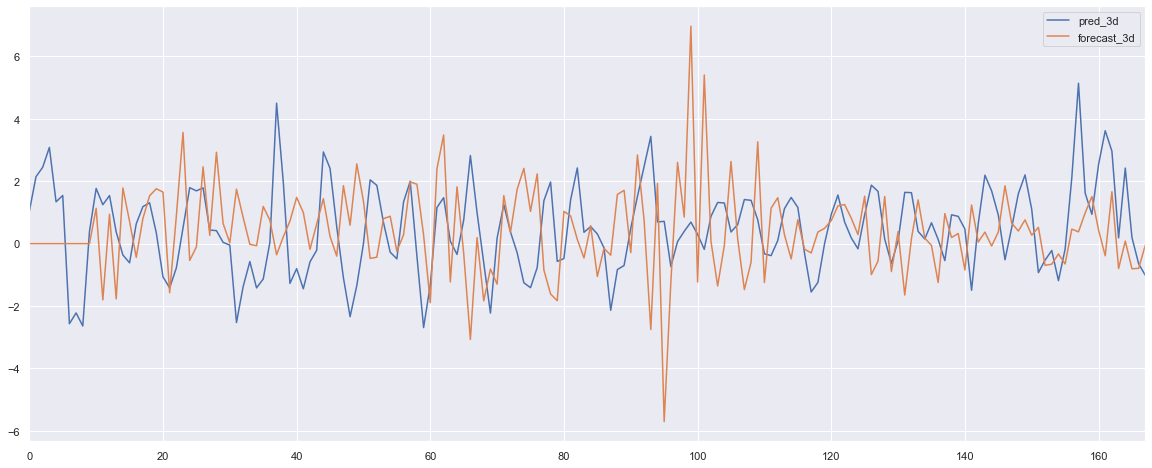

In [38]:
mf_df[['pred_3d', 'forecast_3d']].plot(figsize=(20,8))